In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# Synthetic dataset

In [3]:
np.random.seed(42)
n_samples = 10000

# === Numeric Features ===
feature_num1 = np.random.normal(loc=50, scale=10, size=n_samples)
feature_num2 = np.random.uniform(low=0, high=100, size=n_samples)

# === Categorical Features ===
cat1_choices = ['A', 'B', 'C']
cat2_choices = ['X', 'Y']
cat3_choices = ['Red', 'Green', 'Blue', 'Yellow']

feature_cat1 = np.random.choice(cat1_choices, size=n_samples).astype(object)
feature_cat2 = np.random.choice(cat2_choices, size=n_samples).astype(object)
feature_cat3 = np.random.choice(cat3_choices, size=n_samples).astype(object)

# add in interaction term
interaction_term = np.where(np.isin(feature_cat3, ['Green', 'Blue']), feature_num1 * feature_num2 * 0.005, 0) 


# === Target Variable ===
# Target is a noisy function of inputs + category encodings
target = (
    0.4 * np.nan_to_num(feature_num1)
    + 0.25 * feature_num2
    + np.where(feature_cat1 == 'A', 10, 0)
    + np.where(feature_cat2 == 'X', -5, 5)
    + interaction_term
    + np.random.normal(0, 5, size=n_samples)
)

# Inject outliers
outlier_indices = np.random.choice(n_samples, size=5, replace=False)
feature_num1[outlier_indices[:3]] = feature_num1[outlier_indices[:3]] + 80  # big positive outliers
feature_num2[outlier_indices[3:]] = feature_num2[outlier_indices[3:]] - 120  # big negative outliers

# Inject missing values
missing_indices = np.random.choice(n_samples, size=10, replace=False)
feature_num1[missing_indices[:5]] = np.nan
feature_cat2[missing_indices[5:]] = np.nan

# Combine into DataFrame
df = pd.DataFrame({
    'feature_num1': feature_num1,
    'feature_num2': feature_num2,
    'feature_cat1': feature_cat1,
    'feature_cat2': feature_cat2,
    'feature_cat3': feature_cat3,
    'target': target
})

# Display a sample
df.head(10)


,feature_num1,feature_num2,feature_cat1,feature_cat2,feature_cat3,target
0,54.967142,32.125517,C,Y,Green,50.072471
1,48.617357,10.301919,A,Y,Blue,45.887815
2,56.476885,7.180755,C,Y,Blue,34.817788
3,65.230299,9.427598,C,Y,Blue,35.397206
4,47.658466,58.286936,B,Y,Yellow,47.641281
5,47.658630,5.166218,C,X,Red,20.296309
6,65.792128,33.692687,A,X,Red,39.154831
7,57.674347,75.319970,B,X,Green,48.847664
8,45.305256,29.434817,C,X,Green,31.454895
9,55.425600,76.330808,B,X,Red,42.460479


# EDA
- Explore missing values
- Identify and visualize outliers

- Visualize predictive relationships:
    - Correlation matrix
    - Scatter plots (numeric vs. target)
    - Box plots (categorical vs. target)

### Missing values

In [4]:
missing_summary = df.isnull().sum()
missing_summary

feature_num1    5
feature_num2    0
feature_cat1    0
feature_cat2    5
feature_cat3    0
target          0
dtype: int64

In [5]:
df.feature_cat2.value_counts(dropna=False)

feature_cat2
Y      5100
X      4895
NaN       5
Name: count, dtype: int64

### check distributions of numeric features

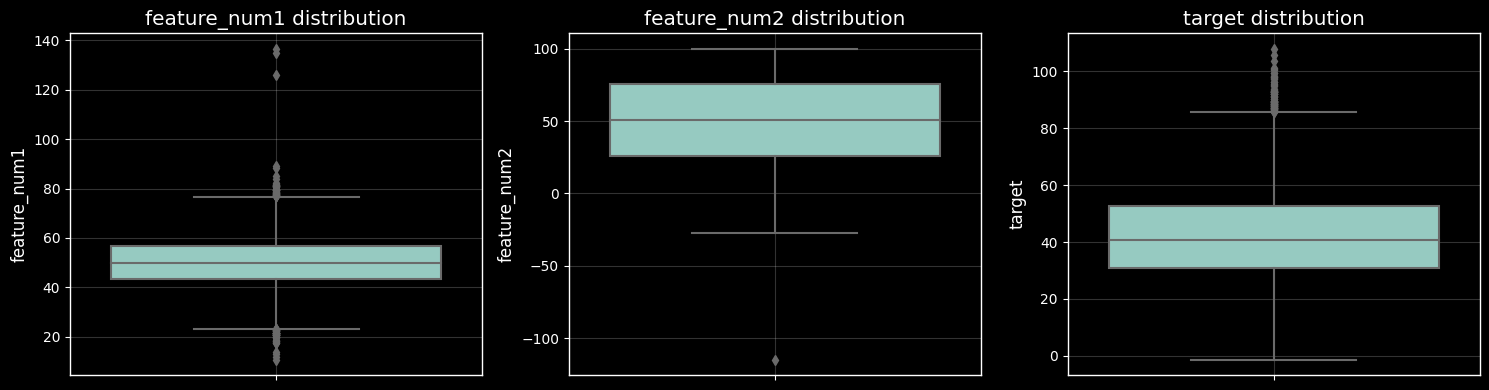

In [6]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(5 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'{col} distribution')
    ax.set_ylabel(col); ax.grid(alpha=0.2)

plt.tight_layout()

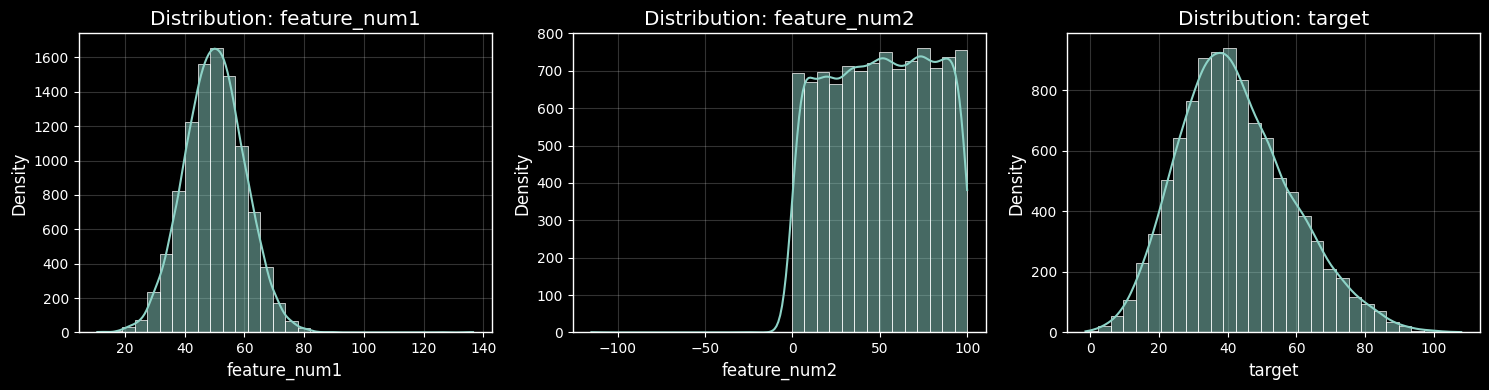

In [7]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(5 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.histplot(df[col], kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution: {col}')
    ax.set_ylabel('Density'); ax.grid(alpha=0.2)

plt.tight_layout()

### Check outliers of numeric features
- can either remove or winsorize depending on application

In [8]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Compute z-scores manually
z_scores = np.abs((df[numeric_features] - df[numeric_features].mean()) / df[numeric_features].std())

# Count outliers (Z > 3)
outliers = (z_scores > 3).sum()
print("Outliers (Z > 3):")
print(outliers)

Outliers (Z > 3):
feature_num1    29
feature_num2     1
target          33
dtype: int64


### Check correlation matrix

In [9]:
# Correlation matrix for numeric variables
numeric_features = ['feature_num1', 'feature_num2', 'target']
corr = df[numeric_features].corr()
corr

,feature_num1,feature_num2,target
feature_num1,1.000000,-0.002677,0.313037
feature_num2,-0.002677,1.000000,0.658034
target,0.313037,0.658034,1.000000


> if you want to include categoricals you have to one hot encode them (oridnal would confuse output)

In [10]:
# Define categorical and numeric columns
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']
numeric_features = ['feature_num1', 'feature_num2', 'target']

# One-hot encode the categoricals
df_onehot = pd.get_dummies(df[categorical_features], drop_first=False)

# Combine with numeric features
df_encoded = pd.concat([df[numeric_features], df_onehot], axis=1)

# Compute correlation matrix
corr_matrix = df_encoded.corr()
# only need to see the ones correlated with the target (its a big matrix otherwise)
corr_matrix['target']

feature_num1           0.313037
feature_num2           0.658034
target                 1.000000
feature_cat1_A         0.262532
feature_cat1_B        -0.129243
feature_cat1_C        -0.133070
feature_cat2_X        -0.312216
feature_cat2_Y         0.311838
feature_cat3_Blue      0.216823
feature_cat3_Green     0.215732
feature_cat3_Red      -0.213906
feature_cat3_Yellow   -0.217958
Name: target, dtype: float64

### Check predictive power of the features

> numeric - scatter plots

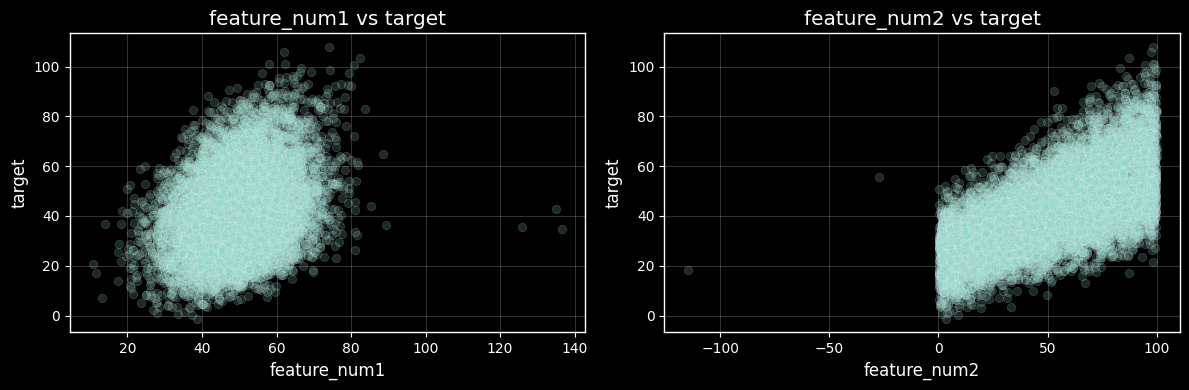

In [11]:
numeric_features = ['feature_num1', 'feature_num2']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(6 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(data=df, x=col, y=target_col, ax=ax, alpha=0.2)
    ax.set_title(f'{col} vs {target_col}')
    ax.set_xlabel(col); ax.set_ylabel(target_col); ax.grid(alpha=0.2)

plt.tight_layout()

> categoricals

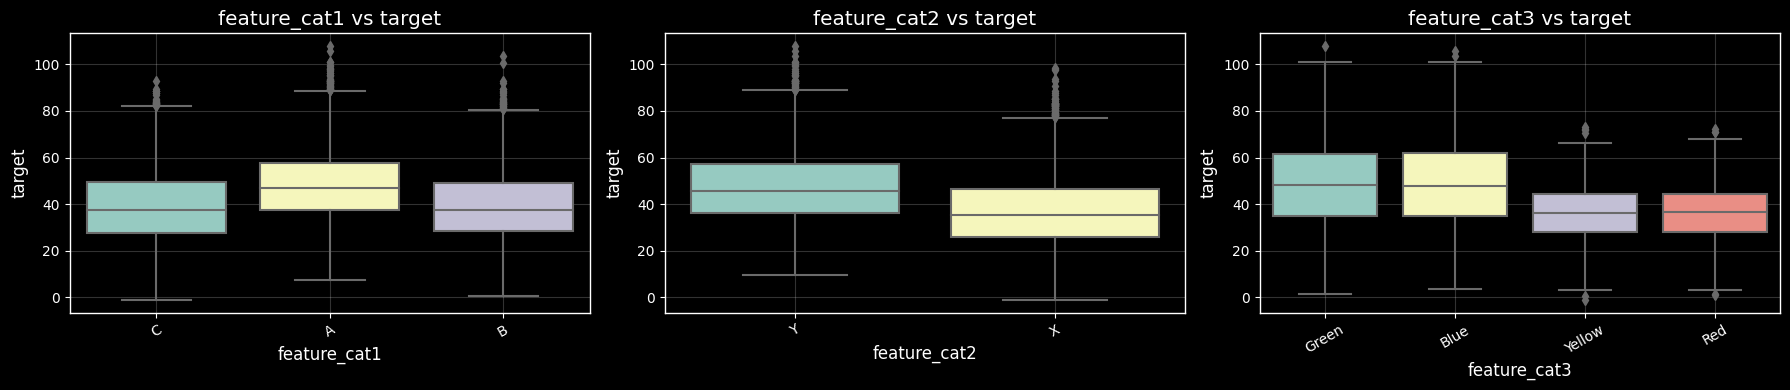

In [12]:
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(6 * len(categorical_features), 4))

for ax, col in zip(axes, categorical_features):
    sns.boxplot(data=df, x=col, y=target_col, ax=ax)
    ax.set_title(f'{col} vs {target_col}')
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(alpha=0.2)

plt.tight_layout()

# Prepare for Training

I have a class that runs a train test split twice to give 3 groups. It then creates a category dtype for each of the cat cols and does nothing with missing values because xgboost handles that innately

In [53]:
from utils.xgb_dset import XgboostDataset

dset = XgboostDataset(df, 
                      targ_col='target', 
                      id_cols=[], 
                      verbose=True)

# train valid test split and encode categoricals
dset.prep_for_tuning(split_type='random', # can be [random, temporal]
                     p_train=0.8, 
                     p_valid=0.1)
# combine train and valid for final training
dset.prep_for_final_training()

Train/valid/test split complete:
	8000 rows train, 
	1000 rows valid, 
	8000 rows test

3 categorical variables encoded

Train and valid set combined for final training:
	9000 rows in "trainvalid" dset


# Tune and Train

### Tune with optuna

In [27]:
from utils.xgb_optuning import XGBoostOptunaTuner

tuner = XGBoostOptunaTuner(dset.X_train, 
                           dset.y_train, 
                           dset.X_valid, 
                           dset.y_valid, 
                           optuna_verbosity='low',
                           problem_type='regression')

tuner.tune_for_nsecs(total_tune_time=30, print_secs=5)

print(tuner.tuned_params)

Elapsed: 6.0sec | Total Iterations: 5
Elapsed: 11.0sec | Total Iterations: 10
Elapsed: 17.0sec | Total Iterations: 17
Elapsed: 23.0sec | Total Iterations: 25
Elapsed: 29.0sec | Total Iterations: 31
{'max_depth': 6, 'learning_rate': 0.09025560772362934, 'subsample': 0.9785977616385588, 'colsample_bytree': 0.9958218233758341, 'lambda': 0.6795913824193317, 'min_child_weight': 14.545459958617787, 'n_estimators': 171}


> ability to train for a little longer

In [28]:
print('lets tune a little longer...')
tuner.tune_for_nsecs(total_tune_time=10, print_secs=5)

print(tuner.tuned_params)

lets tune a little longer...
Elapsed: 5.0sec | Total Iterations: 40
Elapsed: 10.0sec | Total Iterations: 47
{'max_depth': 6, 'learning_rate': 0.09025560772362934, 'subsample': 0.9785977616385588, 'colsample_bytree': 0.9958218233758341, 'lambda': 0.6795913824193317, 'min_child_weight': 14.545459958617787, 'n_estimators': 171}


### Retrain final model

We can see we've recovered the noise of 5 (even with the interaction term)

In [31]:
from xgboost import XGBRegressor
from utils.ml_evals import ContinuousEvals

# Wrap the model as an XGBRegressor from sklearn
xgb_model = XGBRegressor(**tuner.training_params) # enable cats and hist already included
xgb_model.fit(dset.X_trainvalid, dset.y_trainvalid) 

# predict on test set
preds_test = xgb_model.predict(dset.X_test)
preds_train = xgb_model.predict(dset.X_trainvalid)

# Evaluate
train_evals = ContinuousEvals(dset.y_trainvalid, preds_train)
test_evals  = ContinuousEvals(dset.y_test, preds_test)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

train


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,4.416316,0.104305,3.494613,0.082536,-0.000503,-4.529874


test


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,5.351579,0.124346,4.315027,0.100262,0.026371,26.371287


# Feature importances
- 'gain': average improvement in loss when the feature is used in a split (most informative).

- 'weight': number of times a feature is used in splits (can overvalue repeated but weak features).

- 'cover': average coverage (number of samples affected) per split involving the feature.

## sklearn

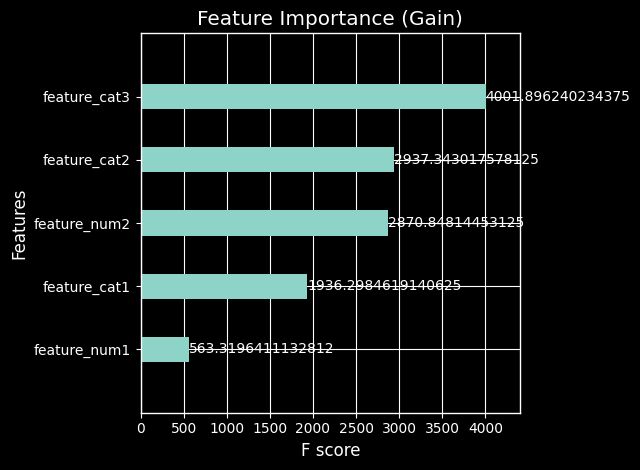

In [32]:
import xgboost as xgb

# Assign feature names to the booster (for plotting)
xgb_model.feature_names = list(dset.X_train.columns)

# Plot importance (by gain, cover, or weight)
xgb.plot_importance(
    xgb_model,
    importance_type='gain',   # ['gain','weight', 'cover']
    max_num_features=10,      
    height=0.4
)
plt.title("Feature Importance (Gain)")
plt.tight_layout()

## Shap

- each feature’s global impact on the prediction distribution.

- Color encodes the feature value (low = blue, high = red).

- Horizontal axis is the SHAP value: how much a feature contributes (positively or negatively) to the prediction.

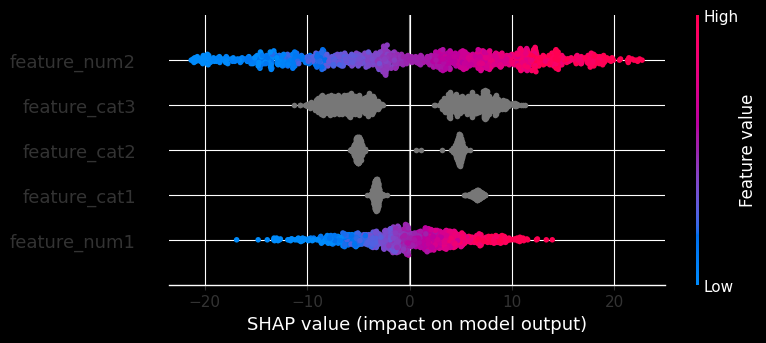

In [33]:
import shap

# Load JS visualization support
shap.initjs()

# Use TreeExplainer for XGBoost model
explainer = shap.Explainer(xgb_model)

# Compute SHAP values on the test set
shap_values = explainer(dset.X_test)

# Convert feature names for SHAP plots
shap_values.feature_names = list(dset.X_test.columns)

# Summary plot (global importance)
shap.plots.beeswarm(shap_values, max_display=10)

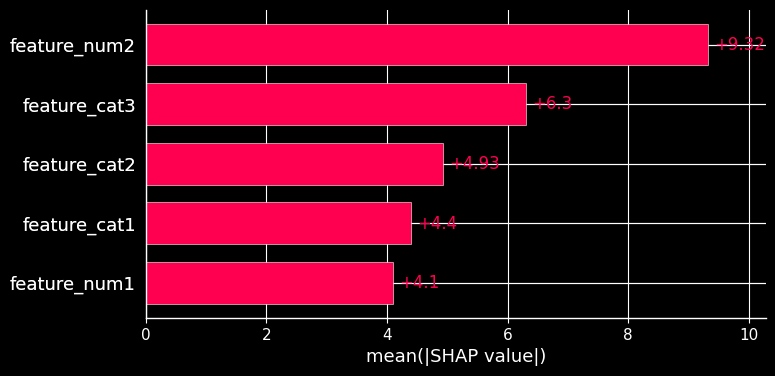

In [34]:
# Bar plot — global mean absolute SHAP value for each feature
shap.plots.bar(shap_values, max_display=10);


> shap pdp see https://docs.google.com/document/d/1YolTNjNTICJn7fNCx1-EB0Z2DoRVbRt-Wk4RDT8xceU/edit?tab=t.0#heading=h.ilo62hh4vx

/home/sfronczak/miniconda3/lib/python3.10/site-packages/shap/plots/_scatter.py:452: RuntimeWarning: invalid value encountered in greater
  min_dist = np.min(diffs[diffs > 1e-8])


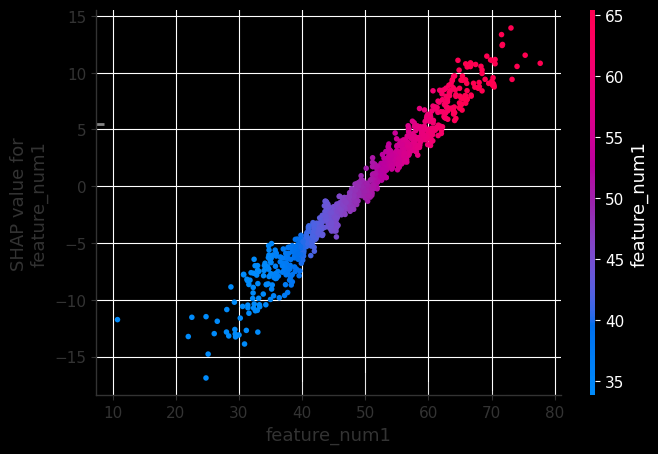

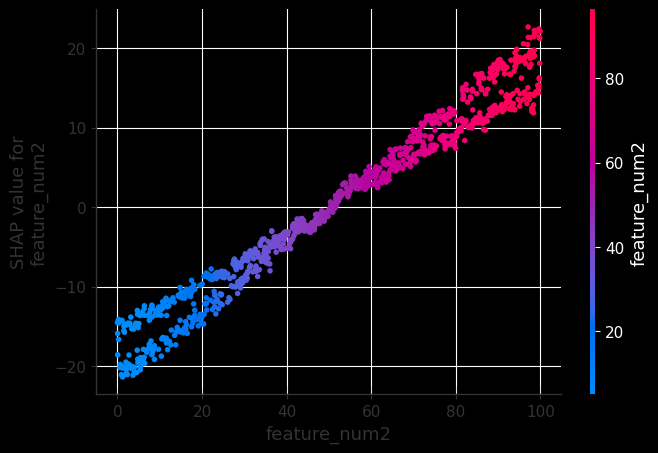

In [35]:
for col in numeric_features:
    shap.plots.scatter(shap_values[:, col], color=shap_values[:, col])

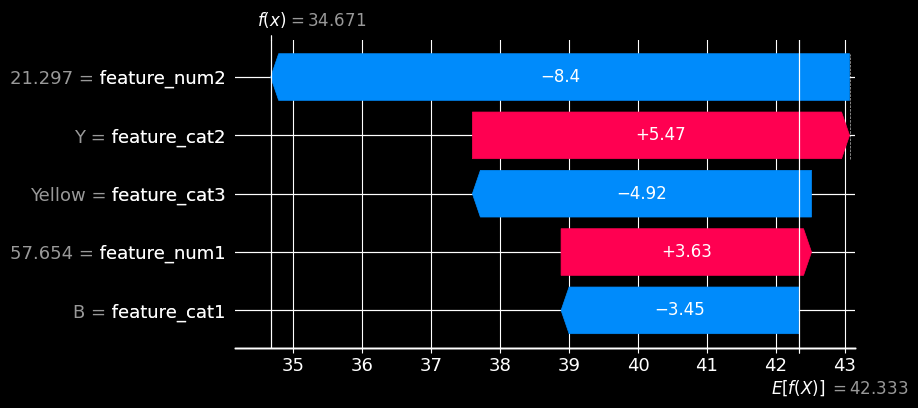

In [36]:
# Example: explanation for the first test instance
shap.plots.waterfall(shap_values[0])

In [37]:
for col in categorical_features:
    print(f"Category mapping for '{col}':")
    print(dict(enumerate(dset.X_test[col].cat.categories)))
    print()

Category mapping for 'feature_cat1':
{0: 'A', 1: 'B', 2: 'C'}

Category mapping for 'feature_cat2':
{0: 'X', 1: 'Y'}

Category mapping for 'feature_cat3':
{0: 'Blue', 1: 'Green', 2: 'Red', 3: 'Yellow'}



## Partial dependence plots (sklearn)

PDPs work best for features with a monotonic or linear influence, though they can still be informative for non-linear ones.

For categorical variables, PDPs assume ordinal relationships (because we encoded them that way). For interpretability, be cautious if the encoding does not represent meaningful order.

See here for explanation : https://docs.google.com/document/d/1YolTNjNTICJn7fNCx1-EB0Z2DoRVbRt-Wk4RDT8xceU/edit?tab=t.0#heading=h.ilo62hh4vx

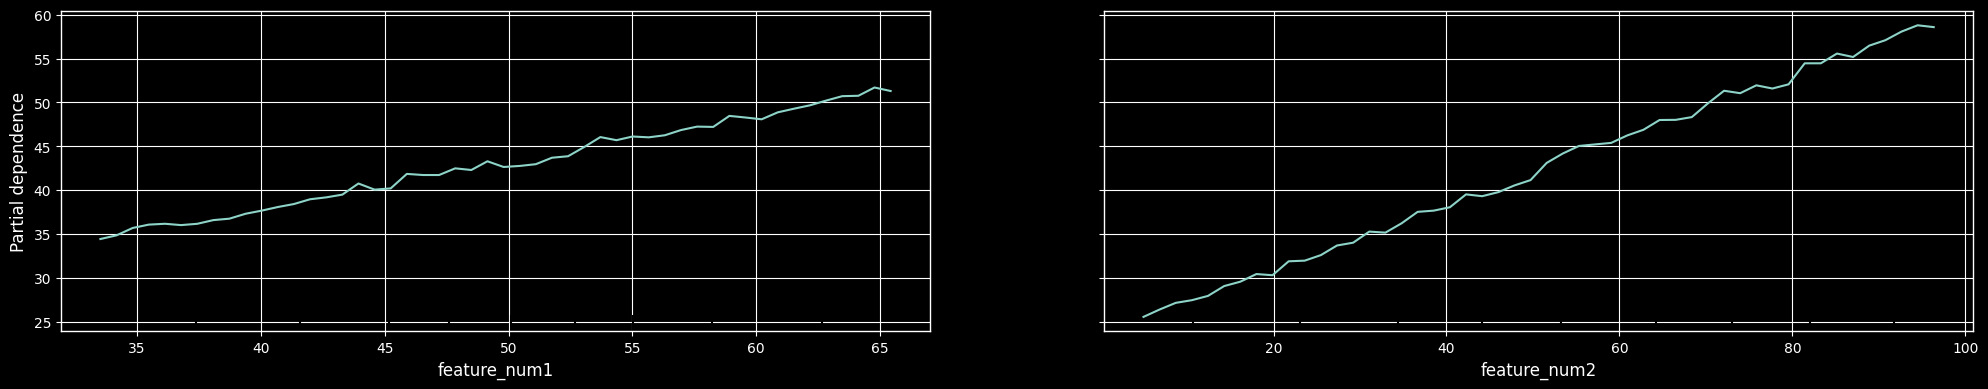

In [38]:
from sklearn.inspection import PartialDependenceDisplay


# Plot PDPs for all features
fig, ax = plt.subplots(figsize=(20, 4))
PartialDependenceDisplay.from_estimator(
    xgb_model,
    dset.X_test,
    features=numeric_features,
    grid_resolution=50,
    ax=ax
)

plt.tight_layout()

> Categoricals

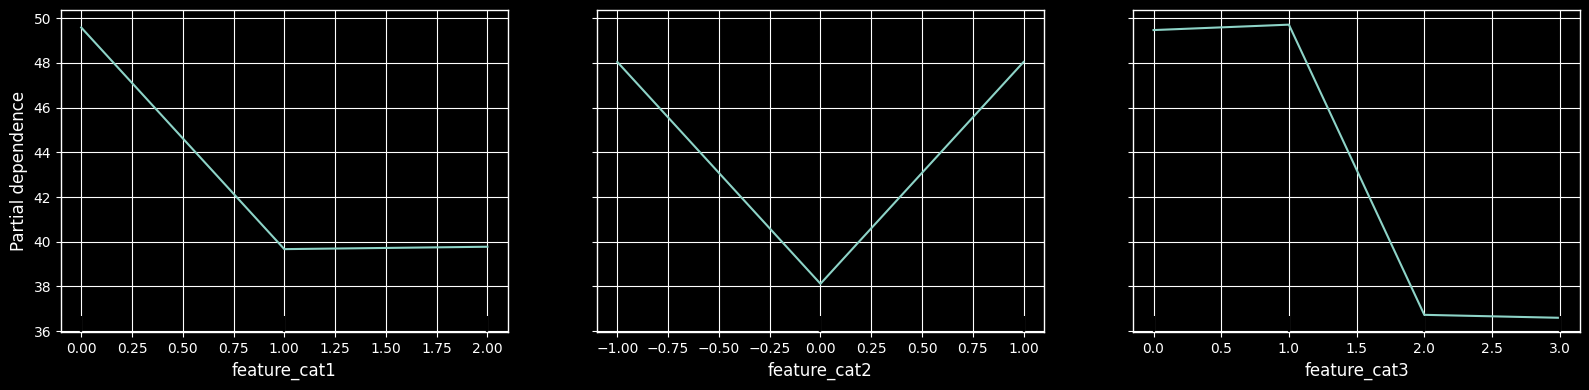

In [39]:
# Encode categorical features as codes
X_test_pdp = dset.X_test.copy()
for col in categorical_features:
    X_test_pdp[col] = X_test_pdp[col].cat.codes

fig, ax = plt.subplots(figsize=(16, 4))

PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_test_pdp,
    features=categorical_features,  # or use index
    grid_resolution=10,
    ax=ax
)
plt.tight_layout()
plt.show()

> 2d

<Figure size 800x600 with 0 Axes>

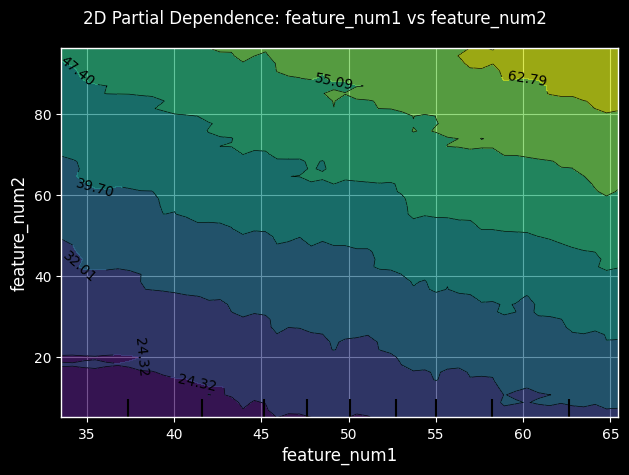

In [40]:
# Define the pair of features you want to analyze
features_2d = [('feature_num1', 'feature_num2')]

# Plot the 2D partial dependence
fig = plt.figure(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(
    xgb_model,            # your fitted XGBRegressor
    X_test_pdp,           # raw DataFrame used for fitting
    features=features_2d,
    grid_resolution=50,
    kind='average',       # default: marginal effect
)

plt.suptitle("2D Partial Dependence: feature_num1 vs feature_num2")
plt.tight_layout()
plt.show()

# Linear regression
See the rmse never quite gets down to 5 because of the interaction term

In [66]:
from utils.linear_dset import LinearDataset

lin_dset = LinearDataset(df, 
                         targ_col='target', 
                         id_cols=[],
                         verbose=True)

# train/valid/test split, encode cats, standardize numerics
lin_dset.prep_for_tuning(split_type='random', 
                         p_train=0.8, 
                         p_valid=0.1)

# combine train and valid for final training
lin_dset.prep_for_final_training()

Train/valid/test split complete:
	8000 rows train, 
	1000 rows valid, 
	8000 rows test

Imputing missing values with mean and mode

3 categorical variables encoded

2 numeric variables standardized

Train and valid set combined for final training:
	9000 rows in "trainvalid" dset


In [70]:
from utils.linear_tune import ridge_grid_search

model, alpha, score, results = ridge_grid_search(lin_dset.X_train, 
                                                 lin_dset.y_train, 
                                                 lin_dset.X_valid, 
                                                 lin_dset.y_valid)

print(f"Best alpha: {alpha}")


train_preds = model.predict(lin_dset.X_trainvalid)
test_preds  = model.predict(lin_dset.X_test)


# Evaluate
train_evals = ContinuousEvals(lin_dset.y_trainvalid, train_preds)
test_evals  = ContinuousEvals(lin_dset.y_test,       test_preds)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

Best alpha: 0.01
train


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,6.40637,0.151088,5.089691,0.120036,0.031784,286.057681


test


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,6.792859,0.15988,5.399503,0.127085,0.012652,12.651526


# testing utils on binary classification

## COnvert the target

> make the target binary classes

In [5]:
df2 = df.copy()
df2.target = (df2.target > df2.target.median()).astype(int)
df2.target.value_counts()

target
1    5000
0    5000
Name: count, dtype: int64

## Eda on binary target
see above for characterizing the feats by themselves

> we can see how the target scales with the numeric features using box plots

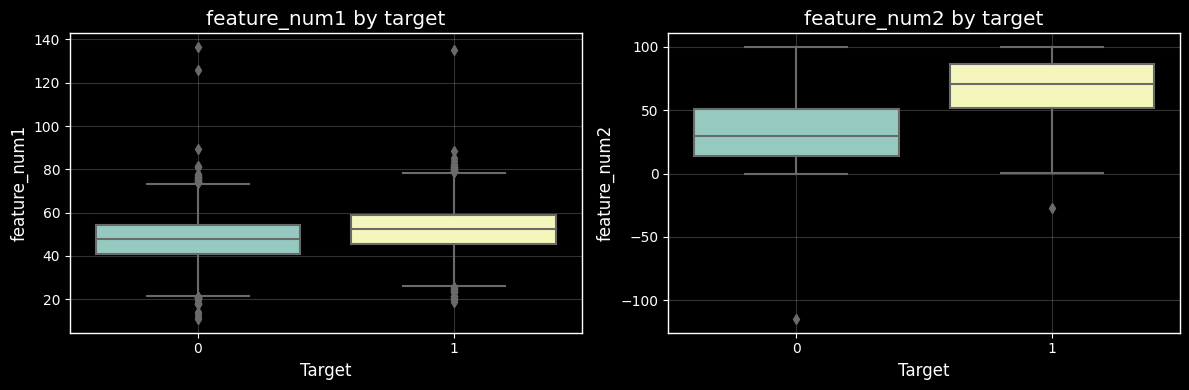

In [11]:
numeric_features = ['feature_num1', 'feature_num2']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(6 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.boxplot(x='target', y=col, data=df2, ax=ax)
    ax.set_title(f'{col} by target')
    ax.set_xlabel('Target'); ax.set_ylabel(col); ax.grid(alpha=0.2)

plt.tight_layout()

> we can check if there are any obvious splits to make on categoricals by looking at joint counts

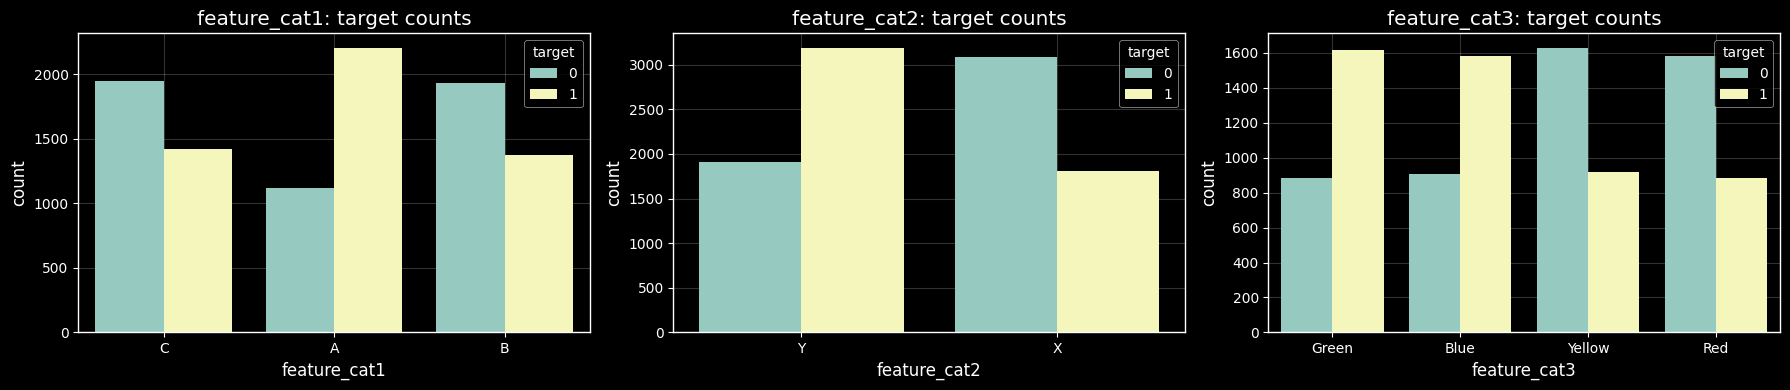

In [16]:
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(6 * len(categorical_features), 4))

for ax, col in zip(axes, categorical_features):
    sns.countplot(x=col, hue='target', data=df2, ax=ax)
    ax.set_title(f'{col}: target counts')
    ax.grid(alpha=0.2)

plt.tight_layout()



## prep data
> I have a class that runs a train test split twice to give 3 groups. It then creates a category dtype for each of the cat cols and does nothing with missing values because xgboost handles that innately

In [72]:
from utils.xgb_dset import XgboostDataset

dset = XgboostDataset(df2, 
                      targ_col='target', 
                      id_cols=[], 
                      verbose=True)

# train valid test split and encode categoricals
dset.prep_for_tuning(split_type='temporal', # can be [random, temporal]
                     p_train=0.8, 
                     p_valid=0.1)
# combine train and valid for final training
dset.prep_for_final_training()

Train/valid/test split complete:
	8000 rows train, 
	1000 rows valid, 
	8000 rows test

3 categorical variables encoded

Train and valid set combined for final training:
	9000 rows in "trainvalid" dset


## Tune and train and XGBoost

In [55]:
from utils.xgb_optuning import XGBoostOptunaTuner

tuner = XGBoostOptunaTuner(dset.X_train, 
                           dset.y_train, 
                           dset.X_valid, 
                           dset.y_valid, 
                           optuna_verbosity='low',
                           problem_type='binary')

tuner.tune_for_nsecs(total_tune_time=30, print_secs=5)

print(tuner.tuned_params)

Elapsed: 5.0sec | Total Iterations: 7
Elapsed: 11.0sec | Total Iterations: 14
Elapsed: 16.0sec | Total Iterations: 20
Elapsed: 21.0sec | Total Iterations: 25
Elapsed: 27.0sec | Total Iterations: 29
{'max_depth': 3, 'learning_rate': 0.15242391728466367, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'lambda': 0.08612579192594885, 'min_child_weight': 11.841156360022783, 'n_estimators': 155}


In [57]:
from xgboost import XGBClassifier
from utils.ml_evals import ClassificationEvals

# Wrap the model as an XGBRegressor from sklearn
xgb_model = XGBClassifier(**tuner.training_params) # enable cats and hist already included
xgb_model.fit(dset.X_trainvalid, dset.y_trainvalid) 

# predict on test set
preds_test = xgb_model.predict(dset.X_test)
preds_train = xgb_model.predict(dset.X_trainvalid)

# Evaluate
train_evals = ClassificationEvals(dset.y_trainvalid, preds_train)
test_evals  = ClassificationEvals(dset.y_test, preds_test)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

train


,f1,recall,precision,accuracy
0,0.902887,0.898864,0.906945,0.903556


test


,f1,recall,precision,accuracy
0,0.899804,0.896282,0.903353,0.898


# Logistic regression
Does a little better than the linear regression probably because the interaction isn't as strong for binary cases (just splitting on median to create classes)

In [58]:
from utils.linear_dset import LinearDataset

lin_dset = LinearDataset(df2, 
                         targ_col='target', 
                         id_cols=[],
                         verbose=True)

# train/valid/test split, encode cats, standardize numerics
lin_dset.prep_for_tuning(split_type='temporal', 
                         p_train=0.8, 
                         p_valid=0.1)

# combine train and valid for final training
lin_dset.prep_for_final_training()

Train/valid/test split complete:
	8000 rows train, 
	1000 rows valid, 
	1000 rows test

Imputing missing values with mean and mode

3 categorical variables encoded

2 numeric variables standardized

Train and valid set combined for final training:
	9000 rows in "trainvalid" dset


In [59]:
from utils.linear_tune import logistic_ridge_grid_search
from utils.ml_evals import ClassificationEvals

model, best_C, best_loss, all_results = logistic_ridge_grid_search(  lin_dset.X_train, 
                                                                     lin_dset.y_train, 
                                                                     lin_dset.X_valid, 
                                                                     lin_dset.y_valid)

print(f"Best C: {best_C}")

train_preds = model.predict(lin_dset.X_trainvalid)
test_preds  = model.predict(lin_dset.X_test)


# Evaluate
train_evals = ClassificationEvals(lin_dset.y_trainvalid, train_preds)
test_evals  = ClassificationEvals(lin_dset.y_test,       test_preds)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

Best C: 100.0
train


,f1,recall,precision,accuracy
0,0.888071,0.88728,0.888864,0.888444


test


,f1,recall,precision,accuracy
0,0.892338,0.900196,0.884615,0.889


## trivial model example
lets just see what a one split model does

In [53]:
from utils.train_test_split import random_row_split, temporal_row_split
from sklearn.tree import DecisionTreeClassifier


class OneSplitModel:
    def __init__(self, df, verbose=False):
        self.verbose = verbose
        self.feat_cols = ['feature_num2']
        self.targ_col = 'target'
        self.df = df
        return
        
    def prep_for_training(self,
                        split_type: str, # ['random', 'temporal']
                        time_col=None, # only used if temporal splitting
                        p_train=0.8):
        '''splits data into ONLY train and test (no tuning)'''
        
        # split into train, valid and test sets
        # split data based on split_type
        if split_type == 'random':
            df_train, df_test = random_row_split(self.df, 
                                                 p_split=p_train)

        elif split_type == 'temporal':
            df_train, df_test = temporal_row_split(self.df, 
                                                   p_split=p_train, 
                                                   time_col=time_col)
        
        # Extract X and y
        self.X_train, self.y_train = df_train[self.feat_cols], df_train[self.targ_col]
        self.X_test,  self.y_test  =  df_test[self.feat_cols],  df_test[self.targ_col]
        if self.verbose:
            print('Train/test split complete:')
            print(f'\t{len(self.y_train)} rows train, \n\t{len(self.y_test)} rows test')
            
        # save dfs to self
        self.df_train, self.df_test = df_train, df_test

        return
    
    def train_single_split(self):
        
        X,y = trivial_model.X_train, trivial_model.y_train

        # Fit decision stump (single split to reduce impurity)
        self.clf = DecisionTreeClassifier(max_depth=1)
        self.clf.fit(X,y)
        
        # Get the split value
        self.split_value = clf.tree_.threshold[0]
        
        if self.verbose:
            print(f"The tree splits on feature: '{self.feat_cols}' at threshold: {self.split_value:.2f}")
        return
    
    def predict(self, X):
        '''predict classes [0,1]'''
        return self.clf.predict(X)
        
    def predict_proba(self, X):
        '''predict prob of class 1'''
        return self.clf.predict_proba(X)[:,1]

> train the model

In [54]:
trivial_model = OneSplitModel(df2, verbose=True)
trivial_model.prep_for_training(split_type='random')
trivial_model.train_single_split()

Train/test split complete:
	8000 rows train, 
	2000 rows test
The tree splits on feature: '['feature_num2']' at threshold: 47.98


> visualize the split

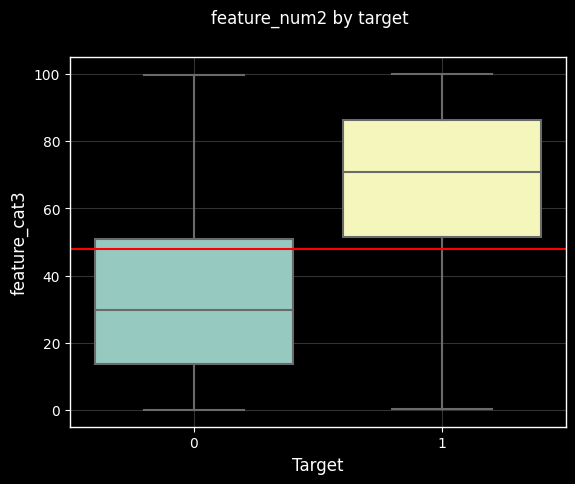

In [50]:
feat_col = 'feature_num2'

sns.boxplot(x='target', y=feat_col, data=trivial_model.df_train)
plt.suptitle(f'{feat_col} by target')
plt.xlabel('Target'); plt.ylabel(col); plt.grid(alpha=0.2)
plt.axhline(trivial_model.split_value, c='r')

> score the model --> not bad but obviously not as good as the others (no overfitting though obviously haha)

In [60]:
from utils.ml_evals import ClassificationEvals

preds_train = trivial_model.predict(trivial_model.X_train)
preds_test  = trivial_model.predict(trivial_model.X_test)

# Evaluate
train_evals = ClassificationEvals(trivial_model.y_train, preds_train)
test_evals  = ClassificationEvals(trivial_model.y_test,       preds_test)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

train


,f1,recall,precision,accuracy
0,0.760437,0.787186,0.735446,0.75325


test


,f1,recall,precision,accuracy
0,0.775647,0.793137,0.758912,0.766
